In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from collections import OrderedDict
from collections import Counter

all_methods = [
    'note_1_text',
    'note_2_text',
    'correction_response (ours, time reference: high-qual note)',
    'correction_response (ours, time reference: avg-qual note)',
    'correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)',
    'correction_response (ours removing retrieval)',
    'correction_response (ours removing image)',
    'correction_response (ours, time reference: tweet)'
]

all_users = [  
    'group1_user1',
    'group1_user2',
    'group2_user1',
    'group2_user2',  
    'group3_user1',
    'group3_user2',
    'group4_user1',
    'group4_user2',
    'group5_user1',
    'group5_user2'
]

path = '../data/'

phase_1_post_ids = ['100', '107', '110', '114', '118', '119', '124', '128', '142', '144', '149', '152', '163', '173', '184']

# process responses
postId_tweetId = pd.read_csv(path + 'tweetid_postid.csv', dtype=str)
df_resp = pd.read_csv(path + 'responses_multimodal.csv', dtype=str)
df_resp = df_resp.merge(postId_tweetId, on='tweet_id', how='left')
df_resp = df_resp.fillna('nan')

# get the post ids whose responses were evaluated by one participant only
userName_tweetIds = pd.read_csv(path + 'username_tweetids.csv', dtype=str)
userName_tweetIds = dict(zip(userName_tweetIds['username'], [tweet_ids.split(';') for tweet_ids in userName_tweetIds['tweet_ids']]))

tweetId_postId = pd.read_csv(path + 'tweetid_postid.csv', dtype=str)
tweetId_postId = dict(zip(tweetId_postId['tweet_id'], tweetId_postId['post_id']))

userName_postIds = {}
for username, tweet_ids in userName_tweetIds.items():
    if username in all_users:
        userName_postIds[username] = [tweetId_postId[tweet_id] for tweet_id in tweet_ids]

userName_postIds_2 = {}
for group_num in range(1, 6):
    u0, u1 = 'group'+str(group_num)+'_user1', 'group'+str(group_num)+'_user2'
    post_ids_u0 = set(userName_postIds[u0])
    post_ids_u1 = set(userName_postIds[u1])
    post_ids_u0_unique = post_ids_u0.difference(post_ids_u1)
    post_ids_u1_unique = post_ids_u1.difference(post_ids_u0)

    userName_postIds_2[u0] = list(post_ids_u0_unique)
    userName_postIds_2[u1] = list(post_ids_u1_unique)
    
# plot setup 
plt.style.use('default')
plt.rcParams['font.family'] = 'Helvetica'

matplotlib.rcParams['font.size'] = 10.5

target_methods_mapping = {
    'correction_response (ours, time reference: tweet)': 'MUSE',
    'correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)': 'GPT-4',
    'note_1_text': 'Laypeople (high)',
    'note_2_text': 'Laypeople (avg)'
}

method_color = {
    'Laypeople (avg)': '#F7E6CC',
    'Laypeople (high)': '#F8D3A6',
    'GPT-4': '#BABFD4',
    'MUSE': '#8798C4'
}

fig_width, fig_height = 2.8, 1.4
line_width = 0.75
font_small, font_medium = 8.5, 9.5
bbox_y = 1.08
l1_x, l2_x, l3_x = 105, 117.5, 130
x_lim = 130

def num_on_stacked_bar(ax, threshold=4):
    i = 1
    for c in ax.containers:
        if i == 1:
            labels = [str(round(v.get_width())) + '%' if v.get_width() > threshold else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center')
            i = 0
        else:
            labels = [round(v.get_width()) if v.get_width() > threshold else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center')
            
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Explicitness of correction

In [2]:
# process annotations
df_eval = pd.read_csv(path + 'Q1-correction_explicitness.csv', dtype=str)
df_eval = df_eval[~df_eval['post_id'].isin(phase_1_post_ids)]
df_eval = df_eval[df_eval['post_id'].isin(df_resp['post_id'])]
    
# get the labels for each approach
data_dict = {method: [] for method in all_methods}
for user in all_users:
    post_ids = df_eval[df_eval['username'] == user]['post_id'].unique()
    for post_id in post_ids:

        method_label = {}

        df = df_eval[(df_eval['username'] == user) & (df_eval['post_id'] == post_id)]

        methods_included = df['response_type'].unique()

        for method in methods_included:
            labels = list(df[df['response_type'] == method]['label'])

            if len(labels) != 1:
                print('ERROR')
            else:
                data_dict[method].append(labels[0])
                if post_id in userName_postIds_2[user]: # need to count one more time
                    data_dict[method].append(labels[0])
                method_label[method] = labels[0]

        methods_excluded = set(all_methods).difference(set(methods_included))
        for method in methods_excluded:
            responses = list(df_resp[df_resp['post_id'] == post_id][method])

            if len(responses) != 1:
                print('ERROR')
            else:
                if responses[0] == 'nan':
                    continue
                elif responses[0] == '~':
                    data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                elif responses[0] == '///':
                    data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                elif responses[0] == '*':
                    data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                elif responses[0] == '$':
                    data_dict[method].append(method_label['correction_response (ours removing image)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing image)'])
                elif responses[0] == '|||':
                    data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])


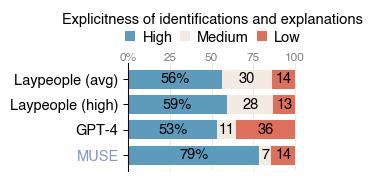

In [3]:
labels_mapping = {
    'Explicit': 'High',
    'Implicit': 'Medium',
    'Unclear': 'Low'
}
label2num = dict(zip(
    labels_mapping.values(), 
    reversed(range(len(labels_mapping.values())))
))

data_dict_2 = {}
for method, labels in data_dict.items():
    if method in target_methods_mapping.keys():
        data_dict_2[target_methods_mapping[method]] = []
        for label in labels:
            data_dict_2[target_methods_mapping[method]].append(labels_mapping[label])

df_plot = pd.DataFrame(columns=[method for method in target_methods_mapping.values()],
                       index=[label for label in labels_mapping.values()])
for label in labels_mapping.values():
    for method in target_methods_mapping.values():
        df_plot[method][label] = Counter(data_dict_2[method])[label] * 100 / len(data_dict_2[method])
df_plot = df_plot.T

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
df_plot.plot.barh(stacked=True, color=['#5C9BBB', '#F3EBE1', '#DD6F5B'], width=line_width, linewidth=0, ax=ax)
num_on_stacked_bar(ax)

ax.set_xlim(0, x_lim)
ax.set_xticks(ticks=[0, 25, 50, 75, 100], labels=['0%', '25', '50', '75', '100'], color='grey', fontsize=font_small)
ax.set_yticks(ticks=[0, 1, 2, 3], labels=list(df_plot.index))
ax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, axis='x', which='major', pad=-3)

plt.setp(ax.spines.values(), color='k', linewidth=line_width)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_tick_params(width=line_width)
ax.set_axisbelow(True)
ax.grid(axis='x', color='#F3EBE1', linewidth=line_width)
plt.gca().get_yticklabels()[0].set_color('#8798C4')
plt.gca().get_yticklabels()[0].set_fontweight('bold')

lgnd = ax.legend(loc='lower left', facecolor='w', edgecolor='w', framealpha=1, fancybox=False,
                  handlelength=0.7, handletextpad=0.5, borderpad=0.2, labelspacing=0.25, columnspacing=0.5,
                  title='Explicitness of identifications and explanations', bbox_to_anchor=(-0.35, bbox_y), ncol=3)
lgnd._legend_box.align = 'center'

# Accuracy of identification

In [4]:
# process annotations
df_eval = pd.read_csv(path + 'Q2-identification_accuracy.csv', dtype=str)
df_eval = df_eval[~df_eval['post_id'].isin(phase_1_post_ids)]
df_eval = df_eval[df_eval['post_id'].isin(df_resp['post_id'])]
    
# get the labels for each approach
data_dict = {method: [] for method in all_methods}
for user in all_users:
    post_ids = df_eval[df_eval['username'] == user]['post_id'].unique()
    for post_id in post_ids:

        method_label = {}

        df = df_eval[(df_eval['username'] == user) & (df_eval['post_id'] == post_id)]

        methods_included = df['response_type'].unique()

        for method in methods_included:
            labels = list(df[df['response_type'] == method]['label'])

            if len(labels) != 1:
                print('ERROR')
            else:
                data_dict[method].append(labels[0])
                if post_id in userName_postIds_2[user]: # need to count one more time
                    data_dict[method].append(labels[0])
                method_label[method] = labels[0]

        methods_excluded = set(all_methods).difference(set(methods_included))
        for method in methods_excluded:
            responses = list(df_resp[df_resp['post_id'] == post_id][method])

            if len(responses) != 1:
                print('ERROR')
            else:
                if responses[0] == 'nan':
                    continue
                elif responses[0] == '~':
                    data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                elif responses[0] == '///':
                    data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                elif responses[0] == '*':
                    data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                elif responses[0] == '$':
                    data_dict[method].append(method_label['correction_response (ours removing image)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing image)'])
                elif responses[0] == '|||':
                    data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])

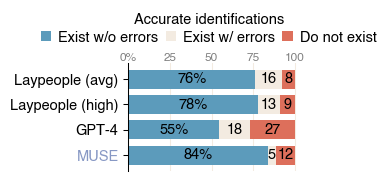

In [5]:
labels_mapping = {
    'Exist without misidentification': 'Exist w/o errors',
    'Exist with misidentification': 'Exist w/ errors',
    'Do not exist': 'Do not exist'
}
label2num = dict(zip(
    labels_mapping.values(), 
    reversed(range(len(labels_mapping.values())))
))

data_dict_2 = {}
for method, labels in data_dict.items():
    if method in target_methods_mapping.keys():
        data_dict_2[target_methods_mapping[method]] = []
        for label in labels:
            data_dict_2[target_methods_mapping[method]].append(labels_mapping[label])
        
df_plot = pd.DataFrame(columns=[method for method in target_methods_mapping.values()],
                       index=[label for label in labels_mapping.values()])
for label in labels_mapping.values():
    for method in target_methods_mapping.values():
        df_plot[method][label] = Counter(data_dict_2[method])[label] * 100 / len(data_dict_2[method])
df_plot = df_plot.T

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
df_plot.plot.barh(stacked=True, color=['#5C9BBB', '#F3EBE1', '#DD6F5B'], width=line_width, linewidth=0, ax=ax)
num_on_stacked_bar(ax)

ax.set_xlim(0, x_lim)
ax.set_xticks(ticks=[0, 25, 50, 75, 100], labels=['0%', '25', '50', '75', '100'], color='grey', fontsize=font_small)
ax.set_yticks(ticks=[0, 1, 2, 3], labels=list(df_plot.index))
ax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, axis='x', which='major', pad=-3)

plt.setp(ax.spines.values(), color='k', linewidth=line_width)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_tick_params(width=line_width)
ax.set_axisbelow(True)
ax.grid(axis='x', color='#F3EBE1', linewidth=line_width)
plt.gca().get_yticklabels()[0].set_color('#8798C4')
plt.gca().get_yticklabels()[0].set_fontweight('bold')

lgnd = ax.legend(loc='lower left', facecolor='w', edgecolor='w', framealpha=1, fancybox=False,
                  handlelength=0.7, handletextpad=0.5, borderpad=0.2, labelspacing=0.25, columnspacing=0.5,
                  title='Accurate identifications', bbox_to_anchor=(-0.45, bbox_y), ncol=3)
lgnd._legend_box.align = 'center'

# Comprehensiveness of accuracy identification

In [6]:
# process annotations
df_eval = pd.read_csv(path + 'Q2.1-identification_comprehensiveness.csv', dtype=str)
df_eval = df_eval[~df_eval['post_id'].isin(phase_1_post_ids)]
df_eval = df_eval[df_eval['post_id'].isin(df_resp['post_id'])]

# get the labels for each approach
data_dict = {method: [] for method in all_methods}
for user in all_users:
    post_ids = df_eval[df_eval['username'] == user]['post_id'].unique()
    for post_id in post_ids:

        method_label = {}

        df = df_eval[(df_eval['username'] == user) & (df_eval['post_id'] == post_id)]

        methods_included = df['response_type'].unique()

        for method in methods_included:
            labels = list(df[df['response_type'] == method]['label'])

            if len(labels) != 1:
                print('ERROR')
            else:
                data_dict[method].append(labels[0])
                if post_id in userName_postIds_2[user]: # need to count one more time
                    data_dict[method].append(labels[0])
                method_label[method] = labels[0]

        methods_excluded = set(all_methods).difference(set(methods_included))
        for method in methods_excluded:
            responses = list(df_resp[df_resp['post_id'] == post_id][method])

            if len(responses) != 1:
                print('ERROR')
            else:
                if responses[0] == 'nan':
                    continue
                elif responses[0] == '~':
                    data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                elif responses[0] == '///':
                    data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                elif responses[0] == '*':
                    data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                elif responses[0] == '$':
                    data_dict[method].append(method_label['correction_response (ours removing image)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing image)'])
                elif responses[0] == '|||':
                    data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])

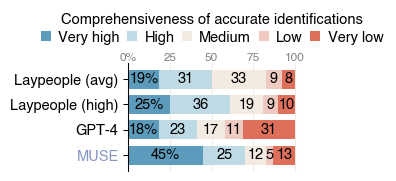

In [7]:
labels_mapping = {
    'Extremely High': 'Very high',
    'High': 'High',
    'Medium': 'Medium',
    'Low': 'Low',
    'No': 'Very low'
}
label2num = dict(zip(
    labels_mapping.values(), 
    reversed(range(len(labels_mapping.values())))
))

data_dict_2 = {}
for method, labels in data_dict.items():
    if method in target_methods_mapping.keys():
        data_dict_2[target_methods_mapping[method]] = []
        for label in labels:
            data_dict_2[target_methods_mapping[method]].append(labels_mapping[label])
        
df_plot = pd.DataFrame(columns=[method for method in target_methods_mapping.values()],
                       index=[label for label in labels_mapping.values()])
for label in labels_mapping.values():
    for method in target_methods_mapping.values():
        df_plot[method][label] = Counter(data_dict_2[method])[label] * 100 / len(data_dict_2[method])
df_plot = df_plot.T

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
df_plot.plot.barh(stacked=True, color=['#5C9BBB', '#BEDAE5', '#F3EBE1', '#EECAC0', '#DD6F5B'], width=line_width, linewidth=0, ax=ax)
num_on_stacked_bar(ax)

ax.set_xlim(0, x_lim)
ax.set_xticks(ticks=[0, 25, 50, 75, 100], labels=['0%', '25', '50', '75', '100'], color='grey', fontsize=font_small)
ax.set_yticks(ticks=[0, 1, 2, 3], labels=list(df_plot.index))
ax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, axis='x', which='major', pad=-3)

plt.setp(ax.spines.values(), color='k', linewidth=line_width)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_tick_params(width=line_width)
ax.set_axisbelow(True)
ax.grid(axis='x', color='#F3EBE1', linewidth=line_width)
plt.gca().get_yticklabels()[0].set_color('#8798C4')
plt.gca().get_yticklabels()[0].set_fontweight('bold')

lgnd = ax.legend(loc='lower left', facecolor='w', edgecolor='w', framealpha=1, fancybox=False,
                  handlelength=0.7, handletextpad=0.5, borderpad=0.2, labelspacing=0.25, columnspacing=0.5,
                  title='Comprehensiveness of accurate identifications', bbox_to_anchor=(-0.45, bbox_y), ncol=5)
lgnd._legend_box.align = 'center'

# Accuracy of explanation

In [8]:
# process annotations
df_eval = pd.read_csv(path + 'Q2.2-explanation_accuracy.csv', dtype=str)
df_eval = df_eval[~df_eval['post_id'].isin(phase_1_post_ids)]
df_eval = df_eval[df_eval['post_id'].isin(df_resp['post_id'])]

# get the labels for each approach
data_dict = {method: [] for method in all_methods}
for user in all_users:
    post_ids = df_eval[df_eval['username'] == user]['post_id'].unique()
    for post_id in post_ids:

        method_label = {}

        df = df_eval[(df_eval['username'] == user) & (df_eval['post_id'] == post_id)]

        methods_included = df['response_type'].unique()

        for method in methods_included:
            labels = list(df[df['response_type'] == method]['label'])

            if len(labels) != 1:
                print('ERROR')
            else:
                data_dict[method].append(labels[0])
                if post_id in userName_postIds_2[user]: # need to count one more time
                    data_dict[method].append(labels[0])
                method_label[method] = labels[0]

        methods_excluded = set(all_methods).difference(set(methods_included))
        for method in methods_excluded:
            responses = list(df_resp[df_resp['post_id'] == post_id][method])

            if len(responses) != 1:
                print('ERROR')
            else:
                if responses[0] == 'nan':
                    continue
                elif responses[0] == '~':
                    data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: high-qual note)'])
                elif responses[0] == '///':
                    data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                elif responses[0] == '*':
                    data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing retrieval)'])
                elif responses[0] == '$':
                    data_dict[method].append(method_label['correction_response (ours removing image)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours removing image)'])
                elif responses[0] == '|||':
                    data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])
                    if post_id in userName_postIds_2[user]:  # need to count twice
                        data_dict[method].append(method_label['correction_response (ours, time reference: avg-qual note)'])

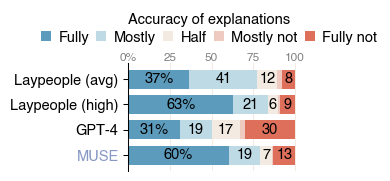

In [9]:
labels_mapping = {
    'Fully Correct': 'Fully',
    'Mostly Correct': 'Mostly',
    'Half': 'Half',
    'Mostly Incorrect': 'Mostly not',
    'Completely Incorrect': 'Fully not'
}
label2num = dict(zip(
    labels_mapping.values(), 
    reversed(range(len(labels_mapping.values())))
))

data_dict_2 = {}
for method, labels in data_dict.items():
    if method in target_methods_mapping.keys():
        data_dict_2[target_methods_mapping[method]] = []
        for label in labels:
            data_dict_2[target_methods_mapping[method]].append(labels_mapping[label])

df_plot = pd.DataFrame(columns=[method for method in target_methods_mapping.values()],
                       index=[label for label in labels_mapping.values()])
for label in labels_mapping.values():
    for method in target_methods_mapping.values():
        df_plot[method][label] = Counter(data_dict_2[method])[label] * 100 / len(data_dict_2[method])
df_plot = df_plot.T

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
df_plot.plot.barh(stacked=True, color=['#5C9BBB', '#BEDAE5', '#F3EBE1', '#EECAC0', '#DD6F5B'], width=line_width, linewidth=0, ax=ax)
num_on_stacked_bar(ax)

ax.set_xlim(0, x_lim)
ax.set_xticks(ticks=[0, 25, 50, 75, 100], labels=['0%', '25', '50', '75', '100'], color='grey', fontsize=font_small)
ax.set_yticks(ticks=[0, 1, 2, 3], labels=list(df_plot.index))
ax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, axis='x', which='major', pad=-3)

plt.setp(ax.spines.values(), color='k', linewidth=line_width)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_tick_params(width=line_width)
ax.set_axisbelow(True)
ax.grid(axis='x', color='#F3EBE1', linewidth=line_width)
plt.gca().get_yticklabels()[0].set_color('#8798C4')
plt.gca().get_yticklabels()[0].set_fontweight('bold')

lgnd = ax.legend(loc='lower left', facecolor='w', edgecolor='w', framealpha=1, fancybox=False,
                  handlelength=0.7, handletextpad=0.5, borderpad=0.2, labelspacing=0.25, columnspacing=0.5,
                  title='Accuracy of explanations', bbox_to_anchor=(-0.45, bbox_y), ncol=5)
lgnd._legend_box.align = 'center'

# Informativeness of explanation

In [10]:
# process annotations
df_eval = pd.read_csv(path + 'Q2.2.1-explanation_informativeness.csv', dtype=str)
df_eval = df_eval[~df_eval['post_id'].isin(phase_1_post_ids)]
df_eval = df_eval[df_eval['post_id'].isin(df_resp['post_id'])]
df_eval['label'] = df_eval['label'].fillna('0')
    
# get the labels for each approach
methods, scores = [], []
for user in all_users:
    post_ids = df_eval[df_eval['username'] == user]['post_id'].unique()
    for post_id in post_ids:
        method_label = {}

        df = df_eval[(df_eval['username'] == user) & (df_eval['post_id'] == post_id)]

        methods_included = df['response_type'].unique()
        for method in methods_included:
            labels = list(df[df['response_type'] == method]['label'])

            if len(labels) != 1:
                print('ERROR')
            else:
                methods.append(method)
                scores.append(labels[0])
                if post_id in userName_postIds_2[user]:
                    methods.append(method)
                    scores.append(labels[0])
                method_label[method] = labels[0]

        methods_excluded = set(all_methods).difference(set(methods_included))
        for method in methods_excluded:
            responses = list(df_resp[df_resp['post_id'] == post_id][method])

            if len(responses) != 1:
                print('ERROR')
            else:
                if responses[0] == 'nan':
                    continue
                elif responses[0] == '~':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours, time reference: high-qual note)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours, time reference: high-qual note)'])
                elif responses[0] == '|||':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours, time reference: avg-qual note)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours, time reference: avg-qual note)'])
                elif responses[0] == '///':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(
                            method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                elif responses[0] == '*':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing retrieval)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours removing retrieval)'])
                elif responses[0] == '$':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing image)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours removing image)'])

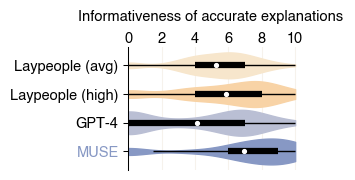

In [11]:
df = pd.DataFrame({
    'Method': methods,
    'Informativeness': scores
})

dict_plot = {}
medians = []
for method in target_methods_mapping.keys():
    scores = list(df[df['Method'] == method]['Informativeness'])
    scores = [int(s) for s in scores if s != 'nan']
    dict_plot[target_methods_mapping[method]] = scores
dict_plot = OrderedDict({method: scores for method, scores in dict_plot.items()})

fig, ax = plt.subplots(figsize=(fig_width, fig_height+0.2))
violins = ax.violinplot(list(dict_plot.values()), widths=0.9, showmeans=False, showmedians=False, showextrema=False, vert=False)

i = 0
for violin in violins['bodies']:
    violin.set_facecolor(method_color[list(dict_plot.keys())[i]])
    violin.set_edgecolor(method_color[list(dict_plot.keys())[i]])
    violin.set_linewidth(1)
    violin.set_alpha(1)
    i += 1

means = [sum(scores) / len(scores) for scores in dict_plot.values()]
for i, labels in enumerate(list(dict_plot.values())):
    quartile1, median, quartile3 = np.percentile(np.array(labels), [25, 50, 75])
    whiskers_min, whiskers_max = adjacent_values(np.sort(labels), quartile1, quartile3)

    ax.scatter(means[i], i + 1, marker='o', color='white', s=7.5, zorder=7.5)
    ax.hlines(i+1, quartile1, quartile3, color='k', linestyle='-', lw=4.5)
    ax.hlines(i+1, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    
plt.xlim(0, x_lim/10)
plt.xticks([0, 2, 4, 6, 8, 10])
plt.xlabel('Informativeness of accurate explanations', x=0.38, labelpad=8)
plt.yticks(ticks=[1, 2, 3, 4], labels=list(dict_plot.keys()))
plt.setp(ax.spines.values(), color='k', linewidth=line_width)
ax.xaxis.set_label_position('top')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_tick_params(width=line_width)
ax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, axis='x', pad=-3)
ax.set_axisbelow(True)
ax.grid(axis='x', color='#F6F2EC', linewidth=line_width)
plt.gca().get_yticklabels()[0].set_color('#8798C4')
plt.gca().get_yticklabels()[0].set_fontweight('bold')